In [ ]:
import glob
import os
import gzip
import pandas as pd
import zarr
import numpy as np


# Function to process a single file and extract a specific column by name
def process_file(input_file, col_index):
    with gzip.open(input_file, 'rt') as f:
            data = np.loadtxt(input_file, delimiter='\t', skiprows=1, usecols=range(2,9))  # Load data from the file, skipping the header
            column = data[:, col_index]  # Select the specified column
            return column  # Remove the first row of the column


#function to calculate proportion of properly mapped reads over a site
def return_prop_mapq(input_file):
    data = np.loadtxt(input_file, delimiter='\t', skiprows=1, usecols=range(2,9))  # Load data from the file, skipping the header
    column =data[:, 1] / data[:, 0]  # Remove the first row of the column
    column[np.isnan(column)] = 0
    return column

#dict of colnames and indices
colname_dict = {0:'reads_all',1:'reads_pp', 2:'reads_mapq0',3:'reads_mapq0_pp',4:'reads_mapq0_pp',5:'rms_mapq',6:'rms_mapq_pp',7:'max_mapq',8:'max_mapq_pp'}

# Pattern to match input files
input_pattern = '*.test.gz'  # Adjust the pattern to match your files

# List of input files
input_files = glob.glob(input_pattern)

# Select column indices for each of the desired columns
column_indices = [0, 1, 3, 6]

for index in column_indices:

    #init indname
    sep = '_'
    stripped = input_file.split(sep, 1)[0]

    #init zarr
    zarrname = colname_dict[index]

    # Save concatenated array as zarr 
    out_zarr = f"data/{colname_dict[index]}.zarr"

    root = zarr.open(out_zarr, mode='w')


    for input_file in input_files:
        print(f'Collecting {colname_dict[index]} from {input_file}')
        column = process_file(input_file, index)
        sep = '_'
        indname = input_file.split(sep, 1)[0]



    zarr.save(f'data/{output_dir}', concatenated_array)

In [100]:
import dask
import dask.array as da
from dask.diagnostics import ProgressBar
import zarr
import numpy as np
import pickle as pkl
import xarray as xr
import glob
import seaborn as sns
from scipy import stats
from dask.distributed import Client
from numba import jit


In [57]:
reads_all = zarr.open('/home/dennist/lstm_data/cease/variants_bycohort/sud.pak.cohort_20231808/results_germline_21.8.23/data/reads_all.zarr/')

# Pattern to match input files
input_pattern = '*.mapq.gz'  # Adjust the pattern to match your files

# List of input files
input_files = glob.glob(input_pattern)

# Select column indices for each of the desired columns
column_indices = [0, 1, 3, 6]

#for ind in all_indames
stacked_array_list = []
mods = []
#loop to get mode
for file in input_files:
    #init indname
    sep = '_'
    stripped = file.split(sep, 1)[0]
    
    array_1 = da.from_zarr(reads_all[stripped])

    stacked_array_list.append(array_1)


#make combined array from zarr
#allarrays = da.stack(stacked_array_list, axis=1)
#x = allarrays.rechunk(allarrays.chunksize) 

This is taking ages. Let's break down what's taking so long. Starting with calculating the mode.

In [84]:
%%time
#pick an array, subsample some rows
arr = stacked_array_list[0].compute()


CPU times: user 4.3 s, sys: 4.91 s, total: 9.22 s
Wall time: 7.57 s


In [ ]:
%%time
#subsample some rows
sub_arr = np.random.choice(arr, 4_000_000, replace=False)

In [90]:
%%time
mode = stats.mode(stacked_array_list[3])
print("Mode:",mode)

Mode: ModeResult(mode=24.0, count=9888218)
CPU times: user 161 µs, sys: 41 µs, total: 202 µs
Wall time: 191 µs


In [86]:
%time
@jit
def calculate_mode(arr):
    # Initialize variables to store mode and its count
    mode = np.nan
    max_count = 0
    
    # Count occurrences of each unique element
    max_val = np.max(arr)
    counts = np.zeros(int(max_val) + 1, dtype=np.int64)
    for num in arr:
        if not np.isnan(num):
            counts[int(num)] += 1
        
    # Find the element with the highest count
    for i in range(len(counts)):
        if counts[i] > max_count:
            max_count = counts[i]
            mode = i
            
    return mode

# Example usage:
print("Mode:", calculate_mode(arr))

CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 25 µs
Mode: 24.0


So numba is for sure faster than scipy here

In [92]:
%%time
print("Mode:", calculate_mode(stacked_array_list[4].compute()))

Mode: 25.0
CPU times: user 4.92 s, sys: 4.68 s, total: 9.6 s
Wall time: 8.16 s


So it takes 8 seconds to calculate the modal coverage over a single sample. So let's do this for all samples.

In [95]:
modes = []
for arr in stacked_array_list:
    mode = calculate_mode(arr.compute())
    modes.append(mode)


Have a look at the distribution of modes to see if there are any samples we want to filter off the bat

<Axes: ylabel='Count'>

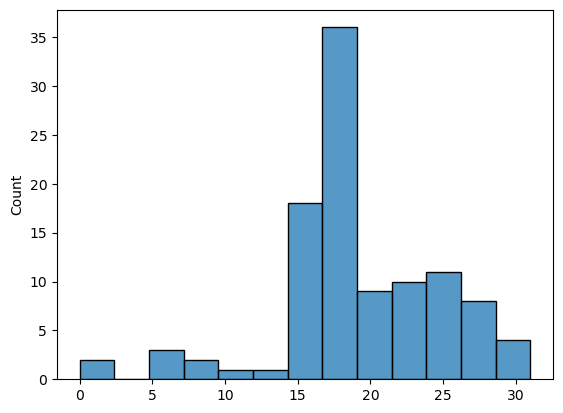

In [119]:
sns.histplot(modes)

Let's remove the samples below 15X

In [120]:
files_over_15 = list(np.array(input_files)[np.array(modes) > 15])

In [124]:
modes_updated = np.array(modes)[np.array(modes) > 15]
overall_mode = np.bincount(list(modes_updated)).argmax()


Now let's have a look at filtering based on modal coverage

In [130]:
arr = stacked_array_list[4].compute()

In [166]:
def return_ind_filter(array, mode):
    zerocov = arr != 0 
    lowcov = arr > (modes[4]/2)
    hicov = arr < (modes[4]*2)
    return(zerocov, lowcov, hicov)

#for all inds
#make arrays containing all of the coverage stats
#then sum acdross them to get proportion of individuals pass/fail each condition

def return_summed_arrays():

    zero_cov_arrays = []
    low_cov_arrays = []
    hi_cov_arrays = []

    for mode, arr in zip(modes, stacked_array_list):

        zerocov, lowcov, hicov = return_ind_filter(arr.compute(), mode)

        zero_cov_arrays.append(zerocov)
        low_cov_arrays.append(lowcov)
        hi_cov_arrays.append(hicov)

    zero_cov_arrays = np.stack(zero_cov_arrays)
    low_cov_arrays = np.stack(low_cov_arrays)
    hi_cov_arrays = np.stack(hi_cov_arrays)

    zero_cov_bool = np.sum(zero_cov_arrays, axis=0)
    low_cov_bool = np.sum(low_cov_arrays, axis=0)
    hi_cov_bool = np.sum(hi_cov_arrays, axis=0)

    return(zero_cov_bool, low_cov_bool, hi_cov_bool)


z,l,h = return_summed_arrays()

# open a file, where you ant to store the data
with open('data/coverage_summary_stats.pkl', 'wb') as f:
    pkl.dump(list[z,l,h], f)

In [176]:
with open('data/modes.pkl', 'wb') as f:
    pkl.dump(modes, f)

In [177]:
with open('data/modes.pkl', 'rb') as f:
    modes = pkl.load(f)

In [179]:
a = 1
b= 'x'
c = 'f'
tuple(a,b,c)

TypeError: tuple expected at most 1 argument, got 3